<a href="https://colab.research.google.com/github/elsioantunes/proc-video/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processamento de video


##init

In [ ]:
import random
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as show
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
    https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html
'''

## Teste 1 - open image


height: 483, width: 359, channels: 3


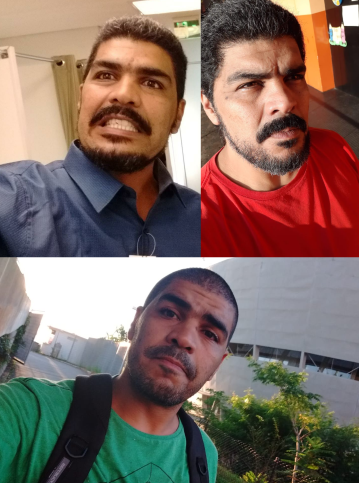

In [ ]:
img = cv.imread('/content/drive/MyDrive/((UFABC))/(proc video)/camisetasMini.png')
height, width, channels = img.shape
print(f'height: {height}, width: {width}, channels: {channels}')
show(img)

## Teste 2 - get pixels



height: 100, width: 100, channels: 3


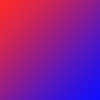

In [ ]:
img = cv.imread('/content/drive/MyDrive/((UFABC))/(proc video)/teste.png')
height, width, channels = img.shape
print(f'height: {height}, width: {width}, channels: {channels}')
show(img)

A título de pesquisa do funcionamento das ferramentas, convém testar qual é o formato retornado do objeto ```img```, que basicamente, é uma lista de listas de listas. Esta img, por ex é uma lista de 100 linhas, onde cada linha é uma lista de 100 pixels, que por sua vez é uma lista de três valores dos canais de cor (blue, green, red). Atenção para o fato de que o pixel é do tipo BGR  e não RGB. Mas isso é só uma inversão dos valores vermelho e azul (não sei por quê)


Fiz uma imagem ```100x100``` com gradiente na diagonal, começando com um tom avermelhado ```(255, 42, 42)``` e terminando com um tom azulado ```(13, 13, 255)``` que me possibilita determinar que o canto superior esquerdo é ```img[0][0]``` e o inferior direito é ```img[99][99]``` com a sequência (blue, green, red) em cada pixel. Aproveito o loop que acessa cada pixel para já fazer esta inversão com ```c [::-1]``` 

Note que os valores não foram exatamente os que determinei porque houve um processo de compactação na imagem. Mas a aproximação é suficiente para a demonstração.

Em seguida, vou colocar estas cores todas em uma lista para em seguida proceder o algoritmo *kmeans*, que me posibilitará um efeito interessante na imagem. O kmeans é formado pelos seguintes procedimentos:


**Color Bag**. Uma lista de cores da imagem. Nessa lista não importam as informações de largura, altura e ordem, presentes na imagem original.

In [ ]:
def Colorbag(img):
    colorbag = []
    for lin in img:
        for c in lin:
            colorbag.append(c[::-1]) 
    return colorbag

colorbag = Colorbag(img)
print ([colorbag[0], colorbag[9999]])

[array([212, 179, 148], dtype=uint8), array([254, 161,  65], dtype=uint8)]


Funções auxiliares nos ajudam a determinar qual cor está mais próxima de uma cor dada. Por exemplo, a cor mais próxima de (0, 0, 255) ou seja Azul puro, na lista de cores da imagem teste está no índice 9999 de ```colorbag```. Esta cor é (16, 14, 252), pois não tem nenhum pixel (0, 0, 255) na imagem teste. Se procurássemos por (255, 0, 0) encontraríamos (254,  41,  43) no índice 0, pois é a cor mais vermelha que temos na imagem. Já, se procurássemos por verde nesta imagem que não tem nenhum verde, encontraríamos a "menos não verde possível", que no caso é (147, 30, 136). Esta cor tem o máximo de verde encontrado no meio do caminho entre os extremos (254,  41,  43) e (16, 14, 252). Veja que o tom avermelhado do canto superior esquerdo tem um pouco mais de verde que o tom azulado do canto inferior direito, fazendo com que o "verde" encontrado tenha, proporcionalmente, mais vermelho que azul. Mas, na verdade, nosso "verde" é um roxo. 

In [ ]:
def distancia(a, b):
  x = a[0] - b[0]
  y = a[1] - b[1]
  z = a[2] - b[2]
  t = x*x + y*y + z*z
  return t

def argminDist(c, vetor):
    argmin = 0
    minDist = 195076     # 255²+255²+255²+1 = maxdist
    for i, cp in enumerate(vetor):
        dist = distancia(c, cp) 
        if dist < minDist:
            minDist = dist
            argmin = i
    return argmin

'''
centros = centrosIniciais(5)
busca = argminDist([255, 0, 0], colorbag)
print (busca, colorbag[busca])

>> 0 [254  41  43]

'''

'\ncentros = centrosIniciais(5)\nbusca = argminDist([255, 0, 0], colorbag)\nprint (busca, colorbag[busca])\n\n>> 0 [254  41  43]\n\n'

**Centroids**. Neste trecho eu produzo uma lista de k centroids. Cada centroid é uma clusterização da lista de cores, de forma que represente uma estimativa de cor principal daquele trecho lista. O algoritmo kmeans vai utilizar estes centros para calcular os próximos centros em iterações até convergir para um conjunto de centros (com as cores mais distantes possíveis entre si) que não se modifica. E então, compararemos cada pixel da imagem original com estes centros, obtendo uma nova imagem com fronteiras de cores bem definidas.

In [ ]:
def centrosIniciaisRND(k):
    colorbag = Colorbag(img)
    myset = set()
    for i in colorbag:
        myset.add(tuple(i))

    uniq = []
    for i in myset:
        uniq.append(list(i))

    n = len(uniq)
    
    centros = []
    for i in range(k):
        rnd = random.randint(0, n)
        centros.append(uniq[rnd])
    return centros


In [ ]:
centros = centrosIniciaisRND(64)
#centros = [[0,0,0],[255,255,255],[255,0,0],[0,255,0],[0,0,255],[255,255,0]]
centros

[[25, 23, 15],
 [85, 57, 65],
 [31, 98, 67],
 [196, 126, 83],
 [169, 1, 2],
 [119, 123, 145],
 [28, 131, 106],
 [146, 99, 103],
 [131, 137, 150],
 [179, 175, 171],
 [197, 162, 140],
 [114, 69, 41],
 [243, 239, 236],
 [166, 132, 123],
 [177, 124, 77],
 [30, 38, 62],
 [31, 17, 8],
 [175, 120, 95],
 [19, 100, 71],
 [74, 79, 106],
 [251, 195, 159],
 [160, 1, 6],
 [95, 55, 64],
 [156, 14, 19],
 [156, 144, 144],
 [26, 24, 17],
 [99, 44, 24],
 [118, 120, 141],
 [59, 69, 77],
 [174, 161, 153],
 [42, 43, 34],
 [169, 111, 99],
 [55, 42, 37],
 [212, 204, 210],
 [121, 34, 15],
 [100, 46, 29],
 [137, 27, 21],
 [231, 218, 212],
 [50, 58, 34],
 [91, 86, 90],
 [175, 19, 21],
 [213, 162, 141],
 [56, 61, 87],
 [69, 69, 89],
 [179, 177, 188],
 [159, 118, 121],
 [132, 97, 77],
 [41, 42, 46],
 [52, 27, 27],
 [97, 77, 87],
 [121, 52, 26],
 [246, 202, 174],
 [115, 73, 80],
 [191, 154, 125],
 [11, 78, 46],
 [155, 139, 135],
 [10, 13, 22],
 [46, 45, 21],
 [103, 118, 113],
 [169, 136, 93],
 [128, 50, 31],
 [253

De posse dos centroids eu percorro a lista de cores atribuindo a cada uma delas um dos centroids por critério de proximidade. Cada centroid então terá seu valor substituído pela média das cores a ele atribuído. Repetindo este processo até uma convergência, que pode ser alcançada em n iterações ou até atingir um epslon mínimo de mudanças nos centros. 


In [ ]:
def iteraCentroids(centros):
    newcentros = []
    count = []
    for i in centros:
        newcentros.append([0,0,0])
        count.append(1)
  
    for c in colorbag:
        i = argminDist(c, centros)
        newcentros[i][0] += c[0]
        newcentros[i][1] += c[1]
        newcentros[i][2] += c[2]
        count[i] += 1        
    
    for i, c in enumerate(centros):
        n = count[i]
        newcentros[i][0] = int ( newcentros[i][0] / n )
        newcentros[i][1] = int ( newcentros[i][1] / n )
        newcentros[i][2] = int ( newcentros[i][2] / n )
    
    return newcentros

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


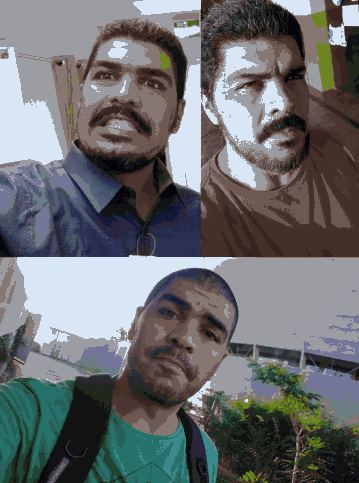

In [ ]:
centros2 = centros.copy()
for i in range(4):
    centros2 = iteraCentroids(centros2)

img2 = img.copy()
for i, lin in enumerate(img):
    for j, c in enumerate(lin):
        cor = centros2[argminDist(c, centros2)]
        img2[i][j] = cor
show(img2)

In [ ]:
img2 = img.copy()
m = [0,0,0]
n = 0
for i, lin in enumerate(img):
    for j, c in enumerate(lin):
        m[0] += c[0]
        m[1] += c[1]
        m[2] += c[2]
        n += 1

print (m[0]/n,m[1]/n,m[2]/n)


98.47318004348402 106.74120082815735 127.65508053772557


In [ ]:
def centrosIniciais(lista_cores,k):
   
  d = 256/k
  centros = []
  for i in range(k):
    centros.append([[0,1],[0,1],[0,1]])
  
  for j in lista_cores:
    for i in range(k):                                   # conta os vermelhos da imagem
      if j[0] >= d + i*d and j[0] < d + (i+1)*d:         # pra tirar uma média
        centros[i][0][0] += j[0]                            # e saber qual vermelho não pode faltar na lista
        centros[i][0][1] += 1
      
      if j[1] >= d + i*d and j[1] < d + (i+1)*d:         # faz o mesmo com o verde
        centros[i][1][0] += j[1]
        centros[i][1][1] += 1
      
      if j[2] >= d + i*d and j[2] < d + (i+1)*d:         # e o azul   
        centros[i][2][0] += j[0]
        centros[i][2][1] += 1
  
  for i in range(k):                 
    centros[i][0] = centros[i][0][0] / centros[i][0][1] # cada centro agora contém as médias 
    centros[i][1] = centros[i][1][0] / centros[i][1][1] # (proporcionais a cada k) das cores 
    centros[i][2] = centros[i][2][0] / centros[i][2][1]

  return centros
  
  